<a href="https://colab.research.google.com/github/lolobq/ECGR-5106-Intro_To_Deep_Learning/blob/main/Homework2/DeepLearningHomework2Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data




In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Problem 2

The baseline model we did in lectures is called ResNet-11. Build a new version of ResNet (ResNet-18). Train it on CIFAR-10. Plot the training loss, validation loss, and validation accuracy. Compare the classification accuracy, and model size across the two versions of ResNet (11, 18). How does the complexity grow as you increase the network depth?

You can find some references for ResNet 18 here:

https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorchLinks to an external site.

Explore the dropout option for the two networks and report your training results and validation accuracy.

In [4]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformation with calculated mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load CIFAR-10 dataset with normalization
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define ResNet-18 architecture
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet-18 model
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

# Initialize the network
net = ResNet18().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

num_epochs = 20

# Training the network
for epoch in range(num_epochs):  # Train for 10 epochs
    net.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)
    training_accuracy = 100 * correct / total
    training_accuracies.append(training_accuracy)

    # Testing the network
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predicted = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            images, labels = inputs.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Update validation accuracy + loss
    validation_loss = running_loss / len(test_loader.dataset)
    validation_losses.append(validation_loss)
    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')

    # Set the model back to training mode
    net.train()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Training Loss: 1.7859032777968082, Validation Loss: 0.047682298159599304, Validation Accuracy: 44.35
Epoch 2/20, Training Loss: 1.2744171161798048, Validation Loss: 0.03498503984212875, Validation Accuracy: 59.79
Epoch 3/20, Training Loss: 0.9783681860468896, Validation Loss: 0.0277709297567606, Validation Accuracy: 68.94
Epoch 4/20, Training Loss: 0.7758896169720441, Validation Loss: 0.027233711522817613, Validation Accuracy: 70.08
Epoch 5/20, Training Loss: 0.6103917524666643, Validation Loss: 0.022341428354382516, Validation Accuracy: 76.28
Epoch 6/20, Training Loss: 0.4691590915028285, Validation Loss: 0.021364924651384353, Validation Accuracy: 77.48
Epoch 7/20, Training Loss: 0.3467431749507394, Validation Loss: 0.021568356646597387, Validation Accuracy: 77.87
Epoch 8/20, Training Loss: 0.24454117762264502, Validation Loss: 0.02004462274387479, Validation A

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

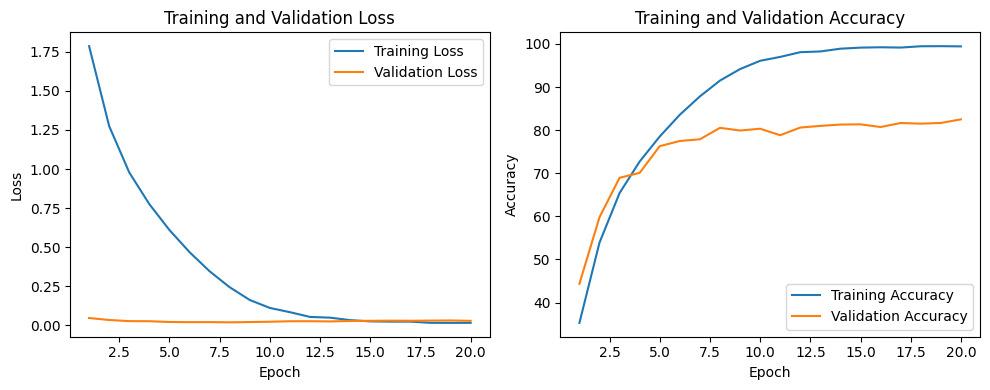

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.92      0.92      0.92      1000
           2       0.81      0.68      0.74      1000
           3       0.63      0.74      0.68      1000
           4       0.80      0.80      0.80      1000
           5       0.80      0.71      0.75      1000
           6       0.86      0.85      0.86      1000
           7       0.87      0.86      0.86      1000
           8       0.90      0.91      0.90      1000
           9       0.87      0.91      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



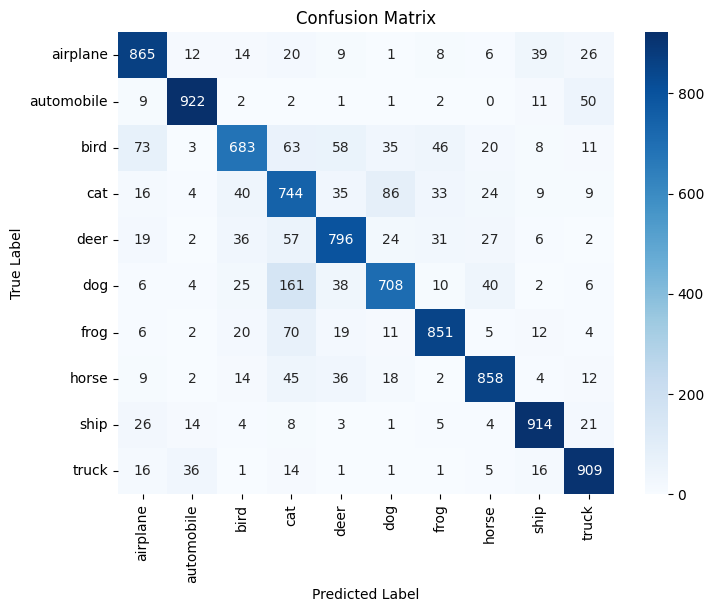

In [5]:
summary(net, (3, 32, 32))  # Input images have shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, num_epochs + 1)

# Plot Training Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, all_predicted)
report = classification_report(true_labels, all_predicted)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()